<a href="https://colab.research.google.com/github/karsarobert/Deep-Learning-2022/blob/main/04/PTE_DL4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning gyakorlat


## 4. gyakorlat: alulillesztés, túl illesztés
### 2022. szeptrember 28.

##### Copyright 2018 The TensorFlow Authors.

In [7]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [8]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Alulillesztés, túlillesztés

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/overfit_and_underfit"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Mint mindig, a példa kódja az `tf.keras` API-t használja, amelyről többet megtudhatsz a TensorFlow [Keras guide](https://www.tensorflow.org/guide/keras) című kiadványban.

Mindkét korábbi példában - [szöveg osztályozása](https://www.tensorflow.org/tutorials/keras/text_classification_with_hub) és [üzemanyag-hatékonyság előrejelzése](https://www.tensorflow.org/tutorials/keras/regression) - azt láttuk, hogy a modellünk pontossága a validációs adatokon a képzés után néhány epochán keresztül tetőzik, majd stagnál vagy csökkenni kezd.

Más szóval, a modellünk *túlilleszkedik* a képzési adatokhoz. Fontos megtanulni, hogyan kezeljük a túlillesztést. Bár gyakran lehetséges nagy pontosságot elérni a *tréningkészleten*, valójában olyan modelleket szeretnénk kifejleszteni, amelyek jól általánosítanak a *tesztkészletre* (vagy olyan adatokra, amelyeket még nem láttak).

A túlillesztés ellentéte az *alkalmazkodás*. Az alulillesztés akkor fordul elő, ha a tréningadatokon még van mit javítani. Ez számos okból történhet: Ha a modell nem elég erős, túlregularizált, vagy egyszerűen csak nem elég hosszú ideig képezték. Ez azt jelenti, hogy a hálózat nem tanulta meg a releváns mintákat a képzési adatokban.

Ha azonban túl sokáig képezzük, a modell elkezd túlilleszkedni, és olyan mintákat tanul a képzési adatokból, amelyek nem általánosíthatók a tesztadatokra. Meg kell találnunk az egyensúlyt. Hasznos készség annak megértése, hogyan kell megfelelő számú epochán keresztül képezni, ahogyan azt alább megvizsgáljuk.

A túlillesztés megelőzésére a legjobb megoldás a teljesebb képzési adatok használata. Az adatkészletnek le kell fednie a bemenetek teljes skáláját, amelyet a modellnek várhatóan kezelnie kell. A további adatok csak akkor lehetnek hasznosak, ha új és érdekes eseteket fednek le.

A teljesebb adatokon betanított modell természetesen jobban általánosít. Ha ez már nem lehetséges, a következő legjobb megoldás az olyan technikák alkalmazása, mint a regularizáció. Ezek korlátozzák a modell által tárolható információk mennyiségét és típusát.  Ha egy hálózat csak kis számú minta memorizálását engedheti meg magának, az optimalizálási folyamat arra kényszeríti, hogy a legkiemelkedőbb mintákra összpontosítson, amelyeknek nagyobb esélyük van a jó általánosításra.

Ebben a füzetben több gyakori regularizációs technikát fogunk megvizsgálni, és ezeket egy osztályozási modell javítására fogjuk használni.




## Setup

Mielőtt elkezdenénk, importáljuk a szükséges csomagokat:

In [9]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers


In [10]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ev5s1nhb
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ev5s1nhb


In [11]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [12]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## The Higgs Dataset

Ennek a bemutatónak nem a részecskefizika a célja, ezért ne foglalkozzunk az adathalmaz részleteivel. Ez 11&#x202F;000&#x202F;000 példát tartalmaz, mindegyik 28 jellemzővel és egy bináris osztálycímkével.

In [13]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816417792/2816407858 [==============================] - 71s 0us/step


In [14]:
FEATURES = 28

A tf.data.experimental.CsvDataset osztály használható csv rekordok közvetlen olvasására egy gzip fájlból, köztes dekompressziós lépés nélkül.

In [15]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

Ez a csv olvasó osztály minden rekordhoz egy skalárokból álló listát ad vissza. A következő függvény a skalárok listáját egy (feature_vector, label) párba csomagolja.

In [16]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

A TensorFlow akkor a leghatékonyabb, ha nagy adattömegeken dolgozik.

Tehát ahelyett, hogy minden sort egyenként újracsomagolna, készítsen egy új adathalmazt, amely 10000 példából álló tételeket vesz fel, alkalmazza a pack_row függvényt minden egyes tételre, majd a tételeket újra felosztja egyedi rekordokra:

In [17]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


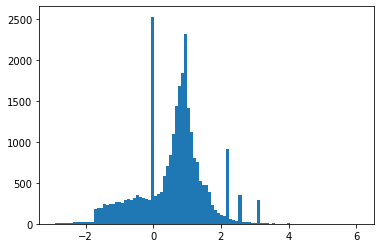

In [18]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

Annak érdekében, hogy ez a bemutató viszonylag rövid legyen, csak az első 1000 mintát használja a validáláshoz, és a következő 10 000 mintát a képzéshez:

In [19]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

A Dataset.skip és Dataset.take módszerek megkönnyítik ezt.

Ugyanakkor használja a Dataset.cache metódust, hogy a betöltőnek ne kelljen minden egyes epochában újra beolvasnia az adatokat a fájlból:

In [20]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [21]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

Ezek az adatkészletek egyedi példákat adnak vissza. Használja a `.batch` metódust a képzéshez megfelelő méretű tételek létrehozásához. A kötegelés előtt ne felejtsük el a `.shuffle` és `.repeat` műveleti halmazt is.

In [22]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Túlillesztés demonstrálása
Túlillesztés demonstrálása
A túlillesztés megelőzésének legegyszerűbb módja, ha egy kis modellel kezdünk: Egy olyan modellel, amelynek kis számú tanulható paramétere van (amit a rétegek száma és a rétegenkénti egységek száma határoz meg). A mélytanulásban a modell tanulható paramétereinek számát gyakran a modell "kapacitásának" nevezik.

Intuitív módon egy több paraméterrel rendelkező modell nagyobb "memorizálási kapacitással" rendelkezik, és ezért könnyen képes lesz megtanulni egy tökéletes szótárszerű leképezést a gyakorló minták és a célpontjaik között, egy olyan leképezést, amelynek nincs általánosító ereje, de ez használhatatlan lenne, amikor korábban nem látott adatokra készítünk előrejelzéseket.

Ezt mindig tartsuk szem előtt: a mélytanulási modellek általában jól illeszkednek a képzési adatokhoz, de az igazi kihívás az általánosítás, nem pedig az illesztés.

Másrészt, ha a hálózat korlátozott kapacitással rendelkezik, nem fogja tudni olyan könnyen megtanulni a leképezést. A veszteség minimalizálása érdekében olyan tömörített reprezentációkat kell megtanulnia, amelyek nagyobb előrejelző képességgel rendelkeznek. Ugyanakkor, ha a modelljét túl kicsivé teszi, akkor nehezen fog illeszkedni a képzési adatokhoz. A "túl sok kapacitás" és a "nem elég kapacitás" között kell egyensúlyozni.

Sajnos nincs varázslatos képlet a modell megfelelő méretének vagy architektúrájának meghatározására (a rétegek számát vagy az egyes rétegek megfelelő méretét tekintve). Különböző architektúrákkal kell kísérleteznie.

A megfelelő modellméret megtalálásához a legjobb, ha viszonylag kevés réteggel és paraméterrel kezd, majd elkezdi növelni a rétegek méretét, vagy új rétegeket ad hozzá, amíg a validációs veszteség csökkenő megtérülését nem látja.

Kezdje egy egyszerű modellel, amely alapként csak a layers.Dense-t használja, majd hozzon létre nagyobb változatokat, és hasonlítsa össze őket.

### Tanítás

Sok modell jobban tanul, ha a tanulás során fokozatosan csökkenti a tanulási sebességet. Az `optimizers.schedules` használatával idővel csökkentheti a tanulási sebességet:

In [23]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

A fenti kód beállít egy `schedules.InverseTimeDecay`-t, amely hiperbolikusan csökkenti a tanulási sebességet az alapsebesség 1/2-ére 1000 epochánál, 1/3-ára 2000 epochánál és így tovább.

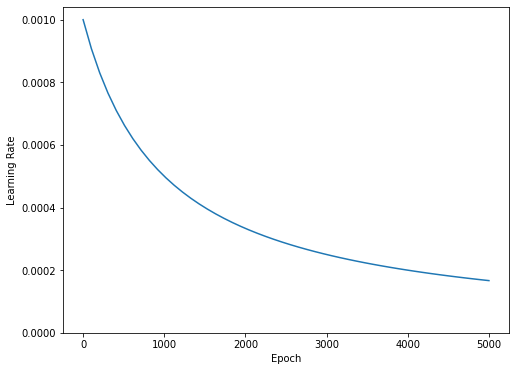

In [24]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


In [25]:
step

array([     0.        ,   2040.81632653,   4081.63265306,   6122.44897959,
         8163.26530612,  10204.08163265,  12244.89795918,  14285.71428571,
        16326.53061224,  18367.34693878,  20408.16326531,  22448.97959184,
        24489.79591837,  26530.6122449 ,  28571.42857143,  30612.24489796,
        32653.06122449,  34693.87755102,  36734.69387755,  38775.51020408,
        40816.32653061,  42857.14285714,  44897.95918367,  46938.7755102 ,
        48979.59183673,  51020.40816327,  53061.2244898 ,  55102.04081633,
        57142.85714286,  59183.67346939,  61224.48979592,  63265.30612245,
        65306.12244898,  67346.93877551,  69387.75510204,  71428.57142857,
        73469.3877551 ,  75510.20408163,  77551.02040816,  79591.83673469,
        81632.65306122,  83673.46938776,  85714.28571429,  87755.10204082,
        89795.91836735,  91836.73469388,  93877.55102041,  95918.36734694,
        97959.18367347, 100000.        ])

Ebben a bemutatóban minden modell ugyanazt a képzési konfigurációt használja. Tehát állítsa be ezeket újrafelhasználható módon, kezdve a visszahívások listájával.

A bemutató tréningje sok rövid korszakon keresztül fut. A naplózási zaj csökkentéséhez használd az `tfdocs.EpochDots`-t, amely egyszerűen kiír egy `.`-t minden korszakhoz, és a metrikák teljes készletét 100 korszakonként.

Ezután tegyük be a `callbacks.EarlyStopping`-t, hogy elkerülje a hosszú és szükségtelen képzési időket. Vegyük észre, hogy ez a callback az `val_binary_crossentropy`, nem pedig az `val_loss` megfigyelésére van beállítva. Ez a különbség később fontos lesz.

A `callbacks.TensorBoard` használatával TensorBoard naplókat generálhatunk a képzéshez.


In [26]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

Hasonlóképpen minden modell ugyanazokat a "Model.compile" és "Model.fit" beállításokat fogja használni:

In [27]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### Tiny model

Kezdje egy modell kiképzésével:

In [28]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [29]:
size_histories = {}

In [30]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4863,  binary_crossentropy:0.7961,  loss:0.7961,  val_accuracy:0.4640,  val_binary_crossentropy:0.7863,  val_loss:0.7863,  
....................................................................................................
Epoch: 100, accuracy:0.5889,  binary_crossentropy:0.6312,  loss:0.6312,  val_accuracy:0.5650,  val_binary_crossentropy:0.6302,  val_loss:0.6302,  
............................................................

Most ellenőrizze, hogyan teljesített a modell:

(0.5, 0.7)

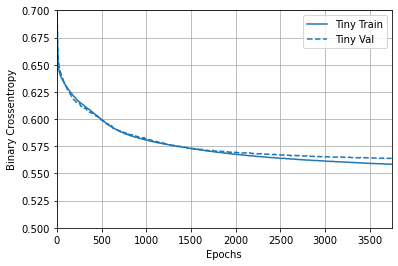

In [31]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### Small model

Hogy lássa, hogy meg tudja-e verni a kis modell teljesítményét, fokozatosan képezzen ki néhány nagyobb modellt.

Próbáljon ki két rejtett réteget egyenként 16 egységgel:

In [32]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [33]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4683,  binary_crossentropy:0.8873,  loss:0.8873,  val_accuracy:0.4870,  val_binary_crossentropy:0.7486,  val_loss:0.7486,  
....................................................................................................
Epoch: 100, accuracy:0.6143,  binary_crossentropy:0.6196,  loss:0.6196,  

### Medium model

Most próbáljon ki 3 rejtett réteget egyenként 64 egységgel:

In [34]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

És képezze a modellt ugyanazokkal az adatokkal:

In [35]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1856      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4747,  binary_crossentropy:0.7097,  loss:0.7097,  val_accuracy:0.4960,  val_binary_crossentropy:0.6844,  val_loss:0.6844,  
....................................

### Large model

Gyakorlásképpen létrehozhat egy még nagyobb modellt, és megnézheti, milyen gyorsan kezd túlilleszkedni.  Ezután adjunk ehhez a benchmarkhoz egy olyan hálózatot, amely sokkal nagyobb kapacitással rendelkezik, sokkal többel, mint amennyit a probléma indokolna:

In [36]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

És ismét képezze a modellt ugyanazokkal az adatokkal:

In [37]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               14848     
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5047,  binary_crossentropy

### A képzési és validálási veszteségek ábrázolása

A folytonos vonalak a képzési veszteséget, a szaggatott vonalak pedig az érvényesítési veszteséget mutatják (ne feledjük: az alacsonyabb érvényesítési veszteség jobb modellt jelez).

Bár egy nagyobb modell felépítése nagyobb teljesítményt biztosít, ha ez a teljesítmény nincs valahogyan korlátozva, akkor könnyen túlilleszkedhet a képzési halmazhoz.

Ebben a példában jellemzően csak az "Apró" modellnek sikerül teljesen elkerülnie a túlillesztést, és a nagyobb modellek mindegyike gyorsabban túlilleszti az adatokat. A `"nagy"` modell esetében ez olyan súlyos, hogy a grafikonon logaritmikus skálára kell váltani ahhoz, hogy valóban lássuk, mi történik.

Ez akkor válik nyilvánvalóvá, ha a validálási metrikákat a képzési metrikákkal ábrázolja és hasonlítja össze.

* Normális, hogy van egy kis különbség.
* Ha mindkét metrika ugyanabba az irányba mozog, akkor minden rendben van.
* Ha az érvényesítési metrika stagnálni kezd, míg a képzési metrika folyamatosan javul, akkor valószínűleg közel áll a túlillesztéshez.
* Ha a validációs metrika rossz irányba halad, a modell egyértelműen túlilleszkedik.

Text(0.5, 0, 'Epochs [Log Scale]')

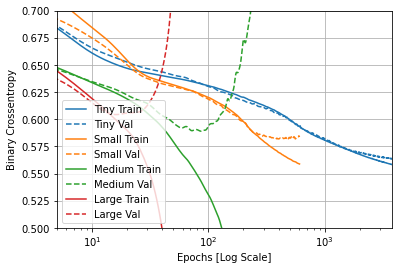

In [38]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

Note: All the above training runs used the `callbacks.EarlyStopping` to end the training once it was clear the model was not making progress.

### Nézet a TensorBoardban

Ezek a modellek mind TensorBoard naplókat írtak a képzés során.

Nyissa meg a beágyazott TensorBoard nézegetőt egy jegyzetfüzetben:

In [39]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

<IPython.core.display.Javascript object>

You can view the [results of a previous run](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It's also included in an `<iframe>` for convenience:

In [40]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

Ha meg szeretné osztani a TensorBoard eredményeit, akkor a naplókat a [TensorBoard.dev](https://tensorboard.dev/) címre töltheti fel a következő kódcellába másolással.

Megjegyzés: Ehhez a lépéshez Google-fiókra van szükség.

```
!tensorboard dev upload --logdir {logdir}/sizes
```

Vigyázat! Ez a parancs nem fejeződik be. Úgy tervezték, hogy folyamatosan feltöltse a hosszú ideig tartó kísérletek eredményeit. Ha az adatok feltöltése megtörtént, akkor a notebook eszközöd "végrehajtás megszakítása" opciójával kell leállítanod.

## Stratégiák a túlillesztés megelőzésére

Mielőtt belemennénk ennek a szakasznak a tartalmába, másoljuk le a fenti `"Tiny"` modell képzési naplóit, hogy összehasonlítási alapként használhassuk.

In [41]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpvlg5vxf0/tensorboard_logs/regularizers/Tiny')

In [42]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Súlyparaméterek regularizációja


Talán ismeri Occam borotvájának elvét: ha valamire két magyarázatot adunk, akkor a legvalószínűbb, hogy a legegyszerűbb magyarázat a helyes, vagyis az, amelyik a legkevesebb feltételezést teszi. Ez a neurális hálózatok által tanult modellekre is érvényes: bizonyos képzési adatok és egy hálózati architektúra mellett többféle súlyértékkészlet (többféle modell) magyarázhatja az adatokat, és az egyszerűbb modellek kevésbé valószínű, hogy túlilleszkednek, mint az összetettek.

Az "egyszerű modell" ebben az összefüggésben olyan modell, amelyben a paraméterértékek eloszlása kisebb entrópiával rendelkezik (vagy olyan modell, amely összességében kevesebb paramétert tartalmaz, amint azt a fenti szakaszban láttuk). A túlillesztés mérséklésének egyik gyakori módja tehát az, hogy a hálózat komplexitását korlátozzák azáltal, hogy a súlyokat csak kis értékekre kényszerítik, ami a súlyértékek eloszlását "szabályosabbá" teszi. Ezt "súlyszabályozásnak" nevezik, és úgy történik, hogy a hálózat veszteségfüggvényéhez hozzáadunk egy olyan költséget, amely a nagy súlyok meglétéhez kapcsolódik. Ez a költség kétféle lehet:

* [L1 regularizáció](https://developers.google.com/machine-learning/glossary/#L1_regularization), ahol a hozzáadott költség arányos a súlyok együtthatóinak abszolút értékével (azaz a súlyok úgynevezett "L1 normájával").

* [L2 regularizáció](https://developers.google.com/machine-learning/glossary/#L2_regularization), ahol a hozzáadott költség arányos a súlyok együtthatóinak négyzetével (azaz a súlyok négyzetre vetített "L2 normájával"). Az L2 regularizációt neurális hálózatokkal összefüggésben súlycsökkenésnek is nevezik. Ne hagyja, hogy az eltérő elnevezés összezavarja: a súlycsökkenés matematikailag pontosan ugyanaz, mint az L2 regularizáció.

Az L1 regularizáció a súlyokat pontosan a nulla felé tolja, ami egy ritka modellt ösztönöz. Az L2 regularizáció büntetni fogja a súlyok paramétereit anélkül, hogy ritkává tenné azokat, mivel a büntetés kis súlyok esetén nullára megy - ez az egyik oka annak, hogy az L2 miért elterjedtebb.

Az `tf.keras` programban a súlyszabályozás a súlyszabályozó példányok kulcsszó-argumentumként történő átadásával adható hozzá a rétegekhez. Adjunk most hozzá L2 súly regularizációt.


In [43]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 512)               14848     
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dense_18 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5052,  binary_crossentropy

Az `l2(0.001)` azt jelenti, hogy a réteg súlymátrixának minden egyes együtthatója `0.001 * súly_együttható_értéke**2` hozzáadódik a hálózat teljes **veszteségéhez**.

Ezért figyeljük közvetlenül a `binary_crossentropy` értéket. Mert nincs benne ez a regularizációs komponens keverve.

Tehát ugyanaz a `"Large"` modell egy `L2` regularizációs büntetéssel sokkal jobban teljesít:


(0.5, 0.7)

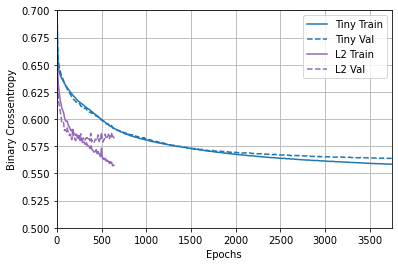

In [44]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

Mint látható, az "L2" regularizált modell sokkal versenyképesebb a "Tiny" modellel szemben. Ez az `"L2"` modell a túlillesztéssel szemben is sokkal ellenállóbb, mint az alapjául szolgáló `"Large"` modell, annak ellenére, hogy ugyanannyi paramétere van.

#### További információ

Két fontos dolgot kell megjegyezni ezzel a fajta regularizációval kapcsolatban.

**Először:** ha saját képzési hurkot írsz, akkor mindenképpen nézd meg a modell regularizációs veszteségeit.

In [45]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

**Másodszor:** Ez a megvalósítás úgy működik, hogy a súlybüntetéseket hozzáadjuk a modell veszteségéhez, majd ezután egy standard optimalizálási eljárást alkalmazunk.

Van egy második megközelítés, amely ehelyett csak a nyers veszteségen futtatja az optimalizálót, majd a számított lépés alkalmazása közben az optimalizáló némi súlycsökkenést is alkalmaz. Ez a "Decoupled Weight Decay" az olyan optimalizálókban látható, mint az `optimizers.FTRL` és az `optimizers.AdamW`.

### Kiesés hozzáadása

A dropout az egyik leghatékonyabb és leggyakrabban használt regularizációs technika a neurális hálózatokhoz, amelyet Hinton és tanítványai fejlesztettek ki a Torontói Egyetemen.

A dropout intuitív magyarázata az, hogy mivel a hálózat egyes csomópontjai nem támaszkodhatnak a többiek kimenetére, minden egyes csomópontnak olyan jellemzőket kell kiadnia, amelyek önmagukban hasznosak.

Az egy rétegre alkalmazott kiesés abból áll, hogy a képzés során véletlenszerűen "kiesik" (azaz nullára állítják) a réteg néhány kimeneti jellemzője. Tegyük fel, hogy egy adott réteg normál esetben egy [0.2, 0.5, 1.3, 0.8, 1.1] vektort adott bemeneti mintára adott vissza a képzés során; a kiesés alkalmazása után ez a vektor néhány véletlenszerűen elosztott nulla bejegyzést fog tartalmazni, pl. [0, 0.5,
1.3, 0, 1.1].

A "kiesési ráta" a nullázásra kerülő jellemzők hányadát jelenti; általában 0,2 és 0,5 között van beállítva. Teszteléskor egyetlen egység sem esik ki, ehelyett a réteg kimeneti értékeit a kiesési rátával megegyező tényezővel csökkentjük, hogy kiegyenlítsük azt a tényt, hogy több egység aktív, mint a képzéskor.

Az `tf.keras`-ban a Dropout rétegen keresztül vezethetünk be kiesést a hálózatba, amely közvetlenül a réteg kimenetére kerül alkalmazásra.

Adjunk hozzá két Dropout réteget a hálózatunkhoz, hogy lássuk, mennyire alkalmasak a túlillesztés csökkentésére:

In [46]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 512)              

(0.5, 0.7)

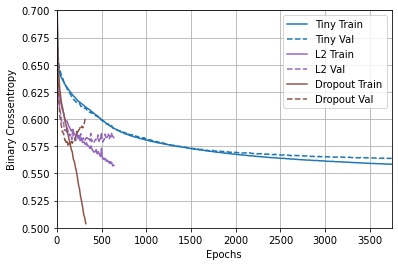

In [47]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

Ebből a diagramból világosan látszik, hogy mindkét regularizációs megközelítés javítja a "nagy" modell viselkedését. De ez még mindig nem veri meg a "Tiny" alapmodellt sem.

Próbáljuk ki legközelebb mindkettőt együtt, és nézzük meg, hogy ez jobban teljesít-e.

### Combined L2 + dropout

In [48]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               14848     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 512)              

(0.5, 0.7)

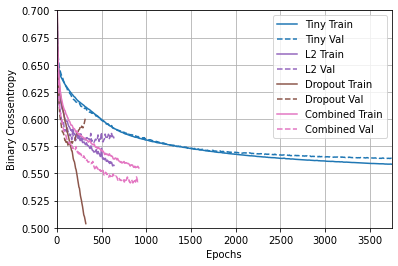

In [49]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

Ez a modell a "kombinált" regularizációval nyilvánvalóan az eddigi legjobb.

### Nézet a TensorBoardban

Ezek a modellek TensorBoard naplókat is rögzítettek.

A beágyazott Tensorboard nézegető megnyitásához egy notebookon belül másolja be a következőt egy kódcellába:

```
%tensorboard --logdir {logdir}/regularizers
```

A [TensorDoard.dev](https://tensorboard.dev/) oldalon megtekintheti a notebook [egy korábbi futtatás eredményeit](https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97).

A könnyebbség kedvéért egy `<<iframe>` keretben is szerepel:

In [1]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")


AttributeError: ignored

This was uploaded with:

```
!tensorboard dev upload --logdir  {logdir}/regularizers
```

## Konklúzió

Összefoglalva: íme a neurális hálózatokban a túlillesztés megelőzésének leggyakoribb módjai:

* Szerezzen több képzési adatot.
* Csökkentse a hálózat kapacitását.
* Adjunk hozzá súlyszabályozást.
* Kiesés hozzáadása.

Két fontos, ebben az útmutatóban nem tárgyalt megközelítés:

* adat-bővítés
* kötegelt normalizálás

Ne feledje, hogy mindegyik módszer önmagában is segíthet, de gyakran a kombinálásuk még hatékonyabb lehet.